# Segmentation Example
> Train a U-Net for pixelwise segmentation of the prostate

In [2]:
'''
Author: skyous 1019364238@qq.com
Date: 2023-12-24 21:51:43
LastEditors: skyous 1019364238@qq.com
LastEditTime: 2024-01-04 20:45:27
FilePath: /prostate158-main/train.ipynb
Description: 

Copyright (c) 2024 by ${git_name_email}, All Rights Reserved. 
'''
import monai
import ignite

from prostate158.utils import load_config
from prostate158.train import SegmentationTrainer
from prostate158.report import ReportGenerator
from prostate158.viewer import ListViewer

All parameters needed for training and evaluation are set in `anatomy.yaml` file. 

In [3]:
config = load_config('anatomy.yaml') # change to 'tumor.yaml' for tumor segmentation
monai.utils.set_determinism(seed=config.seed)

In [10]:
config.transforms.prob

0.175

Create supervised trainer for segmentation task

In [ ]:
trainer=SegmentationTrainer(
    progress_bar=True, 
    early_stopping = True, 
    metrics = ["MeanDice", "HausdorffDistance", "SurfaceDistance"],
    save_latest_metrics = True,
    config=config
)

Adding a learning rate scheduler for one-cylce policy. 

In [ ]:
trainer.fit_one_cycle()

Let's train. This can take several hours. 

In [ ]:
trainer.run()

Finish the training with final evaluation of the best model. To allow visualization of all outputs, add OutputStore handler first. Otherwise only output form the last epoch will be accessible. 

In [ ]:
eos_handler = ignite.handlers.EpochOutputStore()
eos_handler.attach(trainer.evaluator, 'output')

In [ ]:
trainer.evaluate(checkpoint='models/<model-name>.pt')

Generate a markdown document with segmentation results

  0%|          | 0/500 [00:00<?, ?it/s]

anatomy_baseline_1/output


  0%|          | 0/500 [00:00<?, ?it/s]


ValueError: 'tracing' is not a valid TraceKeys

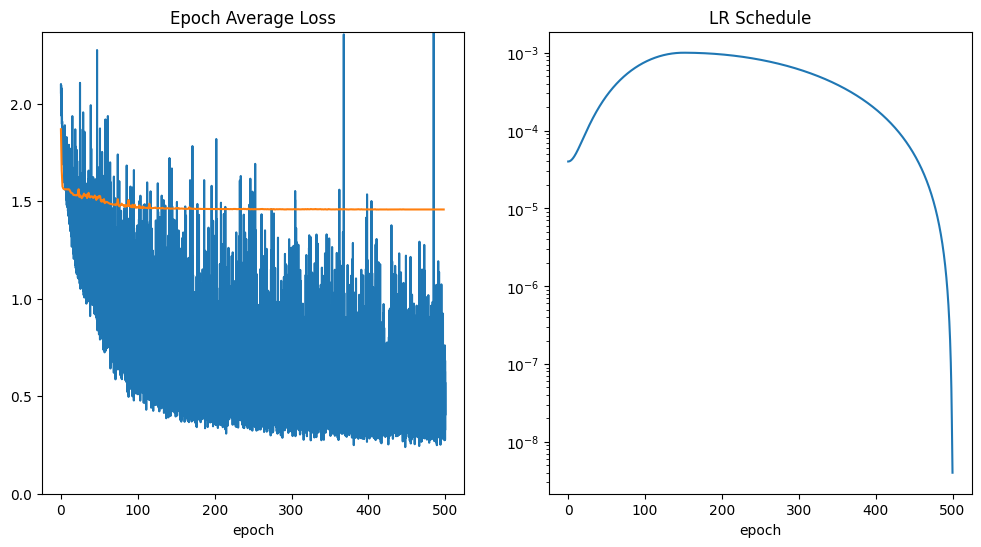

In [2]:
report_generator=ReportGenerator(
    'anatomy_baseline_1', 
    'anatomy_baseline_1/output', 
    'anatomy_baseline_1/logs'
)
report_generator.generate_report()

Have a look at some outputs

In [ ]:
output = trainer.evaluator.state.output
keys = ['image', 'label', 'pred']
outputs = {k : [o[0][k].detach().cpu().squeeze() for o in output] for k in keys}

In [ ]:
ListViewer(
    [o.transpose(0,2).flip(-2) for o in outputs['image'][0:3]] + 
    [o.argmax(0).transpose(0,2).flip(-2).float() for o in outputs['label'][0:3]] + 
    [o.argmax(0).transpose(0,2).flip(-2).float() for o in outputs['pred'][0:3]] 
).show()